runs log

- Transformer (6 blocks, 8 heads), trained for 15 minutes, training loss = 1.4386, **validation loss = 1.6684**
- Transformer (2 blocks, 4 heads) @ 11971 params, trained for 6 hours, training loss = 1.6084, **validation loss = 1.7826**
- Transformer (1 blocks, 2 headd) @ 3275 params, trained for 1 hours, training loss = 1.6864, **validation loss = 1.8935**
- Transformer (1 blocks, 2 heads) @ 3275 params, training loss = 2.0824, **validation loss = 2.1663**
- Two Residual MLPs @ 4563 params, training loss = 2.4655, **validation loss = 2.4908**
- [Bigram + Adam @ 65 parameters](https://github.com/SolbiatiAlessandro/ML-system-design/commit/2362e2d0ac59be8afdd78ab9db119b33f8ce6f8d),  training loss = 2.49, **validation loss = 2.52**
- Bigram @ 65 parameters,  training loss = 2.73, **validation loss = 2.72**
- Random Choice, **theoretical loss = 4.17**


these were done on simlar but different task (minigpt-transformer-alessandro) not sure they can be compared
- MLP 3 layer with residual, @ 3795 paarmeters = 15500: train loss = 1.29, validation loss = 1.642946
- [MLP baseline @ 2195 parameters](https://github.com/SolbiatiAlessandro/ML-system-design/commit/c9685b1e5835a05f84c0592773dc9386268b762c), train loss = 1.45, validation loss = 1.71 



# Environment

In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-02-18 03:56:17--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.007s  

2025-02-18 03:56:17 (155 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [1]:
import torch

# 1. Define a device variable. If a GPU is available, use it.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available CUDA devices
    num_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_devices)

    # Get information about the current device
    current_device_id = torch.cuda.current_device()
    print("Current device ID:", current_device_id)

    # Get the name of the current device
    device_name = torch.cuda.get_device_name(current_device_id)
    print("Device name:", device_name)

    # Get detailed device properties
    device_props = torch.cuda.get_device_properties(current_device_id)
    print("Device properties:", device_props)

    # Get memory information
    memory_allocated = torch.cuda.memory_allocated(current_device_id)
    memory_reserved = torch.cuda.memory_reserved(current_device_id)
    print("Memory allocated:", memory_allocated)
    print("Memory reserved:", memory_reserved)
else:
    print("CUDA is not available.")

Using device: cuda
Number of CUDA devices: 1
Current device ID: 0
Device name: NVIDIA RTX A4000
Device properties: _CudaDeviceProperties(name='NVIDIA RTX A4000', major=8, minor=6, total_memory=16108MB, multi_processor_count=48)
Memory allocated: 0
Memory reserved: 0


In [2]:
!nvidia-smi

Fri Feb 21 07:00:57 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   39C    P8    15W / 140W |      3MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
hyperparams = {
    'block_size': 256,
    'dmodel': 384,
    'hidden_layer': 384*4,
    'batch_size': 64,
    'epochs': 100000
}

# Shakespeare dataset

In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
len(text)

1115394

In [7]:
# other tokenizer can use 
# https://github.com/openai/tiktoken
# https://github.com/google/sentencepiece 

characters = set()
for c in text:
    characters.add(c)
vocab_size = len(characters)
int_to_characters = {i: c for i, c in enumerate(characters)}
characters_to_int = {c: i for i, c in enumerate(characters)}


In [7]:
# could also be done w torch.stack
data = [characters_to_int[c] for c in text]
n = int(0.9 * len(data))
train_data = torch.tensor(data[:n], device=device)
val_data = torch.tensor(data[n:], device=device)

In [8]:
train_data.shape, val_data.shape

(torch.Size([1003854]), torch.Size([111540]))

In [9]:
torch.manual_seed(1337)
batch_size = hyperparams['batch_size']
block_size = hyperparams['block_size']

def get_batch(split , batch_size=batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data) - block_size, (batch_size,), device=device)
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [10]:
xb, yb = get_batch('train')
xb.shape, yb.shape

(torch.Size([64, 256]), torch.Size([64, 256]))

In [11]:
xb, yb

(tensor([[56, 54, 12,  ..., 29, 28,  1],
         [28, 45, 15,  ..., 39, 28, 46],
         [39, 28, 44,  ..., 17, 31, 46],
         ...,
         [39,  9, 14,  ..., 17, 15, 45],
         [28,  6, 39,  ..., 23, 45, 15],
         [19, 53, 22,  ...,  6, 56, 45]], device='cuda:0'),
 tensor([[54, 12, 23,  ..., 28,  1,  6],
         [45, 15, 14,  ..., 28, 46, 18],
         [28, 44, 56,  ..., 31, 46, 23],
         ...,
         [ 9, 14, 56,  ..., 15, 45, 21],
         [ 6, 39, 28,  ..., 45, 15, 64],
         [53, 22,  8,  ..., 56, 45, 28]], device='cuda:0'))

In [12]:
print(len(val_data))

111540


# Transformer Architecture

In [8]:
block_size = hyperparams['block_size']
dmodel = hyperparams['dmodel']

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import math

In [10]:
xb, yb = get_batch('train')
xb.shape, yb.shape

NameError: name 'get_batch' is not defined

In [14]:
dmodel = hyperparams['dmodel']
hidden_layer = hyperparams['hidden_layer']

In [15]:
class PositionalEmbeddings(nn.Module):
    def __init__(self, block_size, dmodel, vocab_size, device=device):
        super().__init__()
        positional_embeddings = torch.zeros(block_size, dmodel, device=device)
        for pos in range(block_size):
            for i in range(dmodel // 2):
                denominator = 10000 ** (2 * i / dmodel)
                positional_embeddings[pos, 2*i]   = math.sin(pos / denominator)
                positional_embeddings[pos, 2*i+1] = math.cos(pos / denominator)
        self.register_buffer("positional_embeddings", positional_embeddings)
        self.dmodel = dmodel
        
        self.embeddings = nn.Embedding(vocab_size, dmodel, device=device)
        self.dropout = nn.Dropout(0.10)
        
    def forward(self, x):
        self.out = (self.embeddings(x) + self.positional_embeddings) * math.sqrt(self.dmodel)
        self.out = self.dropout(self.out)
        return self.out

class ResidualMLPLayer(nn.Module):
    def __init__(self, fan_in, hidden_layer_size,device=device):
        # output is going to be fan_in * 2
        super().__init__()
        self.l1 = nn.Linear(fan_in, hidden_layer_size, device=device)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_layer_size, fan_in, device=device)
        self.layer_norm = nn.LayerNorm(fan_in, device=device)
        self.dropout = nn.Dropout(p=0.10)
    
    def forward(self, x):
        mlp = self.l1(x)
        mlp = self.relu(mlp)
        mlp = self.l2(mlp)
        mlp = self.dropout(mlp)
        x = x + self.layer_norm(mlp) 
        self.out = x
        return self.out

    
class ScaledDotProductAttention(nn.Module):
    
    def __init__(self, fan_in, query_size = 64, value_size = 64, device=device):
        # fan_in = embedding_dim
        super().__init__()
        self.query_layer = nn.Linear(fan_in, query_size, device=device)
        self.key_layer = nn.Linear(fan_in, query_size, device=device)
        self.value_layer = nn.Linear(fan_in, value_size, device=device)
        self.query_size = query_size
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        query = self.query_layer(x)
        key = self.key_layer(x)
        attention = (query @ key.transpose(2, 1)) / math.sqrt(self.query_size)
        mask = torch.tril(torch.ones_like(attention, dtype=torch.bool))
        masked_attention = attention.masked_fill(~mask, float('-inf'))
        masked_attention = F.softmax(masked_attention, dim=2)
        
        value = self.value_layer(x)
        x = (masked_attention @ value)
        self.out = x
        return self.out
    
class MultiHeadAttention(nn.Module):
    
    def __init__(self, fan_in, heads=6, query_size = 64, value_size = 64, device=device):
        super().__init__()
        self.value_size = value_size
        self.heads = heads
        self.attention_heads = nn.ModuleList([
            ScaledDotProductAttention(fan_in, query_size, value_size, device) for _ in range(heads)])
        self.linear = nn.Linear(value_size * heads, fan_in, device=device)
        self.norm = nn.LayerNorm(fan_in, device=device)
        self.dropout = nn.Dropout(p=0.20)
        
    def forward(self, x):
        out = [attention_head(x) for attention_head in self.attention_heads]
        out = torch.cat(out, dim=2)
        out = self.linear(out)
        out = self.dropout(out)
        out = out + self.norm(x) 
        self.out = out
        return self.out    

class Transformer(nn.Module):
    def __init__(self, vocab_size, dmodel, device=device):
        super().__init__()
        self.sequential = nn.Sequential(
            PositionalEmbeddings(block_size, dmodel, vocab_size, device=device),
            
            MultiHeadAttention(dmodel),
            ResidualMLPLayer(dmodel, hidden_layer, device=device),
            
            MultiHeadAttention(dmodel),
            ResidualMLPLayer(dmodel, hidden_layer, device=device),
            
            MultiHeadAttention(dmodel),
            ResidualMLPLayer(dmodel, hidden_layer, device=device),
            
            MultiHeadAttention(dmodel),
            ResidualMLPLayer(dmodel, hidden_layer, device=device),
            
            MultiHeadAttention(dmodel),
            ResidualMLPLayer(dmodel, hidden_layer, device=device),
            
            MultiHeadAttention(dmodel),
            ResidualMLPLayer(dmodel, hidden_layer, device=device),
            
            nn.Linear(dmodel, vocab_size, device=device)
        )
        
    def forward(self, x, targets=None):
        logits = self.sequential(x) # B, T, C  
        if targets is None: return logits
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        target = targets.view(B*T)
        loss = F.cross_entropy(logits, target)
        return logits, loss
    
    def generate(self, idx, max_token_generated):
        #        idx = torch.zeros((1, 1), dtype=torch.long, device=device)
        for _ in range(max_token_generated):
            logits = model.forward(idx[:, -block_size:])
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1)
            pred = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, pred), dim=1)
        return idx
        

In [16]:
model = Transformer(vocab_size, dmodel, device=device)
print(f"parameters = {sum(p.numel() for p in model.parameters())}")
model

parameters = 10696769


Transformer(
  (sequential): Sequential(
    (0): PositionalEmbeddings(
      (embeddings): Embedding(65, 384)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): MultiHeadAttention(
      (attention_heads): ModuleList(
        (0-5): 6 x ScaledDotProductAttention(
          (query_layer): Linear(in_features=384, out_features=64, bias=True)
          (key_layer): Linear(in_features=384, out_features=64, bias=True)
          (value_layer): Linear(in_features=384, out_features=64, bias=True)
          (flatten): Flatten(start_dim=1, end_dim=-1)
        )
      )
      (linear): Linear(in_features=384, out_features=384, bias=True)
      (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): ResidualMLPLayer(
      (l1): Linear(in_features=384, out_features=1536, bias=True)
      (relu): ReLU()
      (l2): Linear(in_features=1536, out_features=384, bias=True)
      (layer_norm): LayerNorm((384,), eps=1e-05, elem

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [20]:
epochs = 300000
lossi, vlossi = [], []
#lossi = []

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

#xval, yval = get_batch('val', batch_size=len(val_data))

for epoch in range(epochs):
    # forward
    xb, yb = get_batch('train')
    logits, loss = model(xb, targets=yb)
    lossi.append(loss.item())
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    
    # update
    optimizer.step()
    
    if epoch % 10 == 0:
        
        with torch.no_grad():
            _vloss = []
            for _ in range(1):
                xval, yval = get_batch('val')
                _, vloss = model(xval, yval)
                _vloss.append(vloss.item())
            vloss = sum(_vloss)/len(_vloss)
            vlossi.append(vloss)
            print(f"{epoch}: training loss = {loss.item():.4f}, validation loss = {vloss:.4f}")
    
    if epoch % 3000 == 0:
                # Create a checkpoint dictionary
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': lossi,
            'vloss': vlossi,
        }

        # Save the checkpoint to a file
        torch.save(checkpoint, f'model_checkpoint_18_Feb_A__{epoch}.pth')
            
# 400: training loss = 2.1767, validation loss = 2.2318, 1 block @ 3000
# 400: training loss = 2.0470, validation loss = 2.1139, 2 blocks @ 6355
# 400: training loss = 2.0035, validation loss = 2.0857, 3 blocks @ 9435

#50: training loss = 2.7914, validation loss = 2.7903
#100: training loss = 2.4451, validation loss = 2.4911

# 50: training loss = 2.7557, validation loss = 2.7672
# 100: training loss = 2.5206, validation loss = 2.5144


0: training loss = 4.4460, validation loss = 4.3093
10: training loss = 3.4250, validation loss = 3.4812
20: training loss = 3.3882, validation loss = 3.4097
30: training loss = 3.3834, validation loss = 3.4038
40: training loss = 3.3707, validation loss = 3.3780
50: training loss = 3.3387, validation loss = 3.3556
60: training loss = 3.3396, validation loss = 3.3752
70: training loss = 3.3174, validation loss = 3.3846
80: training loss = 3.3290, validation loss = 3.3988
90: training loss = 3.3601, validation loss = 3.3678
100: training loss = 3.3053, validation loss = 3.3367
110: training loss = 3.2956, validation loss = 3.3513
120: training loss = 3.2899, validation loss = 3.3242
130: training loss = 3.2491, validation loss = 3.2617
140: training loss = 3.1820, validation loss = 3.2368
150: training loss = 3.1679, validation loss = 3.1936
160: training loss = 3.1251, validation loss = 3.1454
170: training loss = 3.0786, validation loss = 3.1106
180: training loss = 3.0546, validation

KeyboardInterrupt: 

In [21]:
with torch.no_grad():
    print("validation loss estimation:")
    _vloss = []
    for i in range(40):
        xval, yval = get_batch('val')
        _, vloss = model(xval, yval)
        if i % 3 == 0:
            print(i, vloss)
        _vloss.append(vloss.item())
    vloss = sum(_vloss)/len(_vloss)
    vlossi.append(vloss)
    print(f"final validation loss = {vloss:.4f}")


validation loss estimation:
0 tensor(2.9898, device='cuda:0')
3 tensor(2.9936, device='cuda:0')
6 tensor(2.9856, device='cuda:0')
9 tensor(2.9844, device='cuda:0')
12 tensor(2.9940, device='cuda:0')
15 tensor(2.9878, device='cuda:0')
18 tensor(2.9857, device='cuda:0')
21 tensor(2.9897, device='cuda:0')
24 tensor(2.9900, device='cuda:0')
27 tensor(2.9904, device='cuda:0')
30 tensor(2.9842, device='cuda:0')
33 tensor(2.9861, device='cuda:0')
36 tensor(2.9997, device='cuda:0')
39 tensor(2.9931, device='cuda:0')
final validation loss = 2.9896


In [75]:
lossi = torch.tensor(lossi)

In [55]:
lossi

tensor([4.3813, 3.9307, 3.7873, 3.7180, 3.6793, 3.6515, 3.6358, 3.6093, 3.5846,
        3.5605, 3.5343, 3.5132, 3.4819, 3.4558, 3.4302, 3.4002, 3.3750, 3.3514,
        3.3232, 3.3098, 3.2920, 3.2759, 3.2607, 3.2409, 3.2119, 3.2049, 3.1797,
        3.1678, 3.1580, 3.1413, 3.1152, 3.1033, 3.0876, 3.0758, 3.0551, 3.0437,
        3.0330, 3.0152, 3.0094, 2.9874, 2.9855, 2.9751, 2.9640, 2.9399, 2.9302,
        2.9260, 2.9165, 2.9054, 2.8906, 2.8835, 2.8693, 2.8682, 2.8541, 2.8477,
        2.8370, 2.8273, 2.8247, 2.8145, 2.8002, 2.7967, 2.7884, 2.7848, 2.7748,
        2.7709, 2.7527, 2.7497, 2.7496, 2.7378, 2.7248, 2.7175, 2.7140, 2.7122,
        2.7077, 2.6968, 2.6910, 2.6789, 2.6776, 2.6722, 2.6638, 2.6570, 2.6593,
        2.6494, 2.6392, 2.6394, 2.6299, 2.6280, 2.6256, 2.6203, 2.6176, 2.6027,
        2.6055, 2.5973, 2.6016, 2.5926, 2.5831, 2.5836, 2.5808, 2.5673, 2.5659,
        2.5624, 2.5662, 2.5531, 2.5490, 2.5429])

In [24]:
lossi = torch.tensor(lossi)

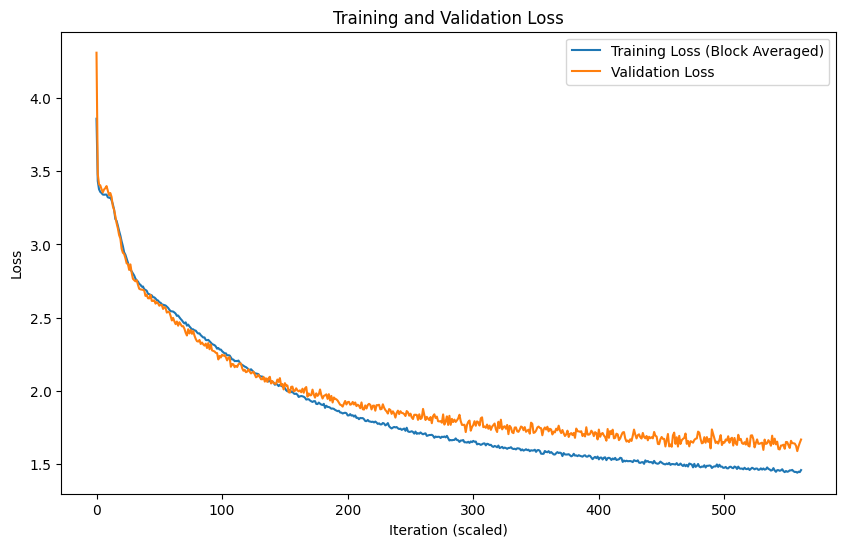

In [25]:
import torch
from matplotlib import pyplot as plt

# Assuming lossi and vlossi are PyTorch tensors.
# Calculate block size based on the length of vlossi:
plot_dim = len(vlossi) * 1

# Compute the averaged training loss:
#   1. Compute how many complete blocks of length plot_dim fit in lossi.
#   2. Slice lossi to that many elements.
#   3. Reshape into (plot_dim, -1) so that each column is one block.
#   4. Take the mean across each row.
avg_loss = lossi[:plot_dim * (lossi.numel() // plot_dim)].view(plot_dim, -1).mean(1)

# Convert tensors to numpy arrays for plotting.
avg_loss_np = avg_loss.cpu().numpy() if avg_loss.is_cuda else avg_loss.numpy()
vlossi_np = vlossi.cpu().numpy() if torch.is_tensor(vlossi) and vlossi.is_cuda else (vlossi.numpy() if torch.is_tensor(vlossi) else vlossi)

# Create x-axis for validation loss: assuming each validation loss corresponds to every 2 steps.
x_val = [i * 1 for i in range(len(vlossi_np))]

plt.figure(figsize=(10, 6))
plt.plot(avg_loss_np, label='Training Loss (Block Averaged)')
plt.plot(x_val, vlossi_np, label='Validation Loss')
plt.xlabel('Iteration (scaled)')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


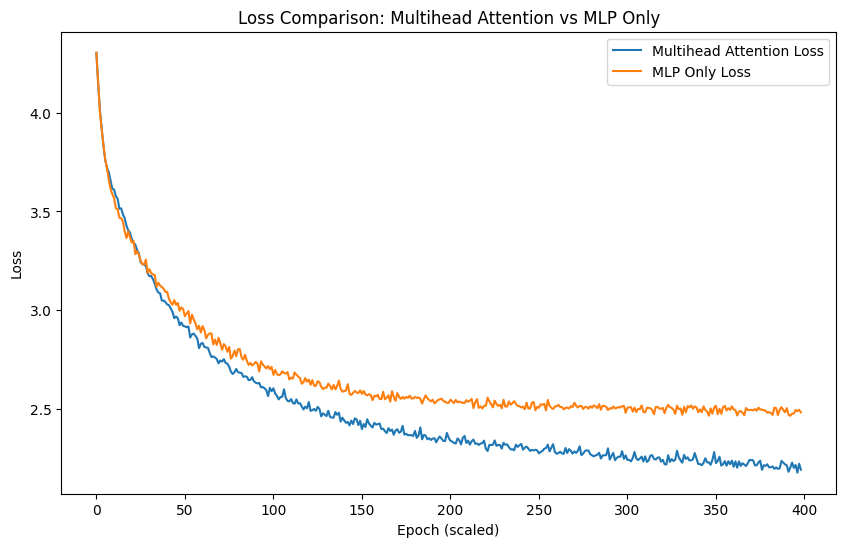

In [283]:
plot_dim = len(vlossi2) * 19

# Compute mean loss values for plotting
lossi_mean = lossi[:plot_dim * (lossi.numel() // plot_dim)].view((plot_dim, -1)).mean(1)
lossi2_mean = lossi2[:plot_dim * (lossi.numel() // plot_dim)].view((plot_dim, -1)).mean(1)

from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lossi_mean, label="Multihead Attention Loss")
plt.plot(lossi2_mean, label="MLP Only Loss")
plt.title("Loss Comparison: Multihead Attention vs MLP Only")
plt.xlabel("Epoch (scaled)")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [184]:
from torch.utils.tensorboard import SummaryWriter
import torch

xb, yb = get_batch('train')

# Assume you have your model defined, e.g.:
# model = MyModel(...)

# Create a SummaryWriter instance
writer = SummaryWriter(log_dir="logs")

# Add the model graph to TensorBoard
writer.add_graph(model, xb)

2025-02-18 05:14:50.468878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-18 05:14:50.469054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-18 05:14:50.532058: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 05:14:50.672882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-18 05:14:52.873732: W tensorflow/compiler/tf2

In [186]:
!tensorboard --logdir . --bind_all

2025-02-18 05:18:17.459218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-18 05:18:17.459298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-18 05:18:17.460814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 05:18:17.469011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-18 05:18:18.613705: W tensorflow/compiler/tf2

In [304]:
idx = torch.ones((1, block_size), dtype=torch.long, device=device)
idx.shape

torch.Size([1, 8])

In [305]:
idx = torch.ones((1, block_size), dtype=torch.long, device=device)
print("".join(int_to_characters[x.item()] for x in model.generate(
    idx, 
    1000
)[0]))

ssssssss.
Fail.

KING LEY:
What
And upon that it with that eighnesday, and I dids
Which thou for Ladly blows John fair and the's prince; in day in this before the wisdow!
And instrument,
God say; but of misses!

MERCUT:
I hope armter, by you that you princess'd us London the me that wors! do not we and did! Angelove his us the lakes unto rest with thou are must all is with toraclan:
Hath of our
ther their for ward's am only shall back in trarth.
CLEOMENENIUS:
Come Sold's deace
As we mark lord, merrince.

BUCGOMINIUS:
It is prime peoplishmence,
For son, mother a wret shal:
I am us crown; say with your seem, tirrah worth hief;
Coverned give I shappery to then formiardower that so
thrun, ne't, we with tneath your compation.

DUCHESS OF YORK:
I have in their vower gooes that your croud, I seein middle makes?
Hark, and so.

KING RICHARD IV:
Yetiful, the grison at her-biion
pit wars their jumph,
Reder from did I.

Saland's all find, the emblant inrow,
Or edid, leizen: need, though a but,
Til

In [306]:
model

Transformer(
  (sequential): Sequential(
    (0): PositionalEmbeddings(
      (embeddings): Embedding(65, 32)
    )
    (1): MultiHeadAttention(
      (attention_heads): ModuleList(
        (0-1): 2 x ScaledDotProductAttention(
          (query_layer): Linear(in_features=32, out_features=64, bias=True)
          (key_layer): Linear(in_features=32, out_features=64, bias=True)
          (value_layer): Linear(in_features=32, out_features=64, bias=True)
          (flatten): Flatten(start_dim=1, end_dim=-1)
        )
      )
      (linear): Linear(in_features=128, out_features=32, bias=True)
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (2): ResidualMLPLayer(
      (l1): Linear(in_features=32, out_features=1028, bias=True)
      (relu): ReLU()
      (l2): Linear(in_features=1028, out_features=32, bias=True)
      (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (3): Linear(in_features=32, out_features=65, bias=True)
  )
)

In [307]:
import torch

# Create a checkpoint dictionary
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': lossi,
}

# Save the checkpoint to a file
torch.save(checkpoint, 'model_checkpoint_17_Feb_A.pth')

# checkpoint loading

In [57]:
# Load the checkpoint
checkpoint = torch.load('model_checkpoint_18_Feb_A__12000.pth')

# Restore the state dictionaries
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print(checkpoint.keys())


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'vloss'])


In [50]:
checkpoint['loss'][-1], checkpoint['vloss'][-1]

(1.6084802150726318, 1.7826149463653564)

In [48]:
lossi[:12000].view(10,-1).mean(1)

tensor([2.0784, 1.7745, 1.7098, 1.6780, 1.6578, 1.6442, 1.6335, 1.6250, 1.6180,
        1.6119])

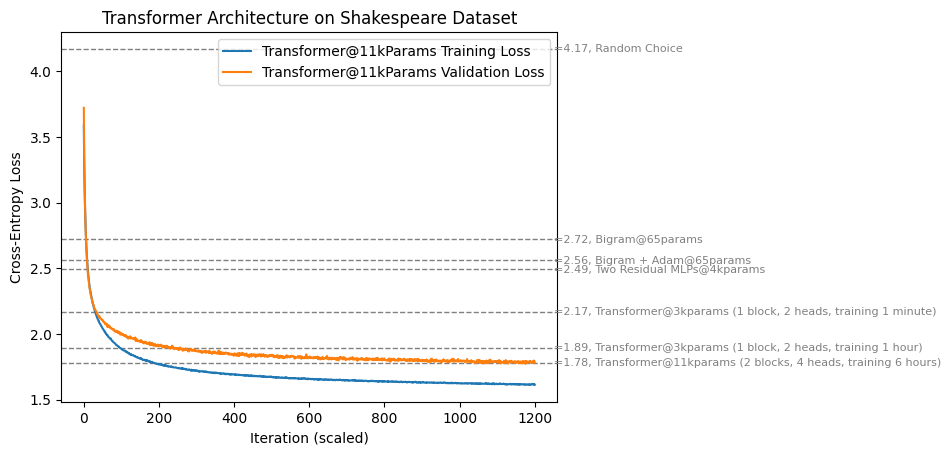

In [76]:
import torch
from matplotlib import pyplot as plt

lossi = torch.tensor(checkpoint['loss'])
vlossi = checkpoint['vloss']
# Assuming lossi and vlossi are PyTorch tensors.
# Calculate block size based on the length of vlossi:
plot_dim = len(vlossi) * 1

# Compute the averaged training loss:
#   1. Compute how many complete blocks of length plot_dim fit in lossi.
#   2. Slice lossi to that many elements.
#   3. Reshape into (plot_dim, -1) so that each column is one block.
#   4. Take the mean across each row.
avg_loss = lossi[:plot_dim * (lossi.numel() // plot_dim)].view(plot_dim, -1).mean(1)

# Convert tensors to numpy arrays for plotting.
avg_loss_np = avg_loss.cpu().numpy() if avg_loss.is_cuda else avg_loss.numpy()
vlossi_np = vlossi.cpu().numpy() if torch.is_tensor(vlossi) and vlossi.is_cuda else (vlossi.numpy() if torch.is_tensor(vlossi) else vlossi)

# Create x-axis for validation loss: assuming each validation loss corresponds to every 2 steps.
x_val = [i * 1 for i in range(len(vlossi_np))]

# List of previous models with their validation loss values.
models = [
    {"name": "Transformer@11kparams (2 blocks, 4 heads, training 6 hours)", "val_loss": 1.7826},
    {"name": "Transformer@3kparams (1 block, 2 heads, training 1 hour)", "val_loss": 1.8935},
    {"name": "Transformer@3kparams (1 block, 2 heads, training 1 minute)", "val_loss": 2.1663},
    {"name": "Two Residual MLPs@4kparams",             "val_loss": 2.4908},
    {"name": "Bigram + Adam@65params",                 "val_loss": 2.56},
    {"name": "Bigram@65params",                        "val_loss": 2.72},
    {"name": "Random Choice",                 "val_loss": 4.17},
]


ax = plt.gca()
x_min, x_max = ax.get_xlim()

# For each model, draw a horizontal dashed line and place the text to the right of the line.
for model in models:
    plt.axhline(y=model["val_loss"], color='gray', linestyle='--', linewidth=1)
    plt.text(x_max * 1250.05, model["val_loss"], f"={model['val_loss']:.2f}, {model['name']}",
             verticalalignment='center', horizontalalignment='left',
             fontsize=8, color='gray')

plt.plot(avg_loss_np, label='Transformer@11kParams Training Loss')
plt.plot(x_val, vlossi_np, label='Transformer@11kParams Validation Loss')
plt.xlabel('Iteration (scaled)')
plt.ylabel('Cross-Entropy Loss')
plt.title('Transformer Architecture on Shakespeare Dataset')
plt.legend()
plt.show()


In [58]:
idx = torch.ones((1, block_size), dtype=torch.long, device=device)
print("".join(int_to_characters[x.item()] for x in model.generate(
    idx, 
    1000
)[0]))

IIIIIIIIIIIIIIIIzi,3hGjwAvGQBhE;vGEshX,KvTXmGAvTwNGkhuXJm,,:ogHIi,fNAGAvhEGJhG?TTW,fXJGvhN?TGuGbwN?AT.AGhXT?GEXUhCT,fGXhQBTG;hhJGC!GCu??T'l,LwAvG?AuN TBB!GQNTu'G!hENGhjXGvw?GsBuU'm,,ZoScGIrGfoqct:ci,3u.hNwX;GJTuNl,$hEGvuJGAvTNTlGwbG!hEX;T?,fXJGC!GjNw T?GAvTG;uBB,KvuAGuAGthCTlG'wBBGAhGUE?wJTN?GAvTwNGusTDsuEBBhj?GwXGC!G?h TNwA!W,HGuCGvT
?GAu'!
?G;w TGhBJGJhhXl,djTTTAGAhGuUBTGuXGcX;BuXJGjhNJGbTAUv&,,aI:oqzHfi,dAEb
?lG?vuBBGCuXhAGsNTJhXlGsTuUT&,,:ftZi,fju!lGwXGCTmGuGAvuA&,Zw?AwB!Gw?lGC!GBhNJ&,,dAuU'W,fXJG?'XhjGwXGguswAhBl,-EAG'Xhj?GEshXGhbGAvTNTGbwTBJGbu?Al,gh?AuXA?GwXGvw?GUuNUTGwXGuGAvThsl,KvTGjwAvGvTGNuC?lGVhjTuN?lGuXJGvTGjwAvhEAG?TBBGwXGjwAvGH?u!lGXTTJbEBBGhbGhhAG!hENGvTNGAvw?&,-wU'lGw?GwAGXhAGAhGAvTG?EssTUATJ,ING?hE;vAGXTj?l,dAuXJhj?,KhGvu TGQEA&,KvuX'GhNWlGAvhEGBujbGhEAN,dsTu'GCTGbhNGATXJTNhE?GJwTGvTGANw Tl,gusEu'TlGjvwBs&,,ZoScGIrG3fozKi,$TumGCu!GvwClGvhB?lGuXJGhXGvTuNJTXlGuJu TGC!GbhNQwJlGuXJGAvTwNGUNwTXUTi,,SHz3GRczt$GaHi,q!GBhNJi,IlGQEAG:hXGfX;eETJGCTGquXAu;ETlGBT??wB!GBTuXUTlGCwX

In [17]:
model

Transformer(
  (sequential): Sequential(
    (0): PositionalEmbeddings(
      (embeddings): Embedding(65, 384)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): MultiHeadAttention(
      (attention_heads): ModuleList(
        (0-5): 6 x ScaledDotProductAttention(
          (query_layer): Linear(in_features=384, out_features=64, bias=True)
          (key_layer): Linear(in_features=384, out_features=64, bias=True)
          (value_layer): Linear(in_features=384, out_features=64, bias=True)
          (flatten): Flatten(start_dim=1, end_dim=-1)
        )
      )
      (linear): Linear(in_features=384, out_features=384, bias=True)
      (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): ResidualMLPLayer(
      (l1): Linear(in_features=384, out_features=1536, bias=True)
      (relu): ReLU()
      (l2): Linear(in_features=1536, out_features=384, bias=True)
      (layer_norm): LayerNorm((384,), eps=1e-05, elem

In [19]:
import torch


# To load the checkpoint:
checkpoint = torch.load("./model_checkpoint_18_Feb_A__12000.pth")  # Use map_location if needed
model.load_state_dict(checkpoint["model_state_dict"])


RuntimeError: Error(s) in loading state_dict for Transformer:
	Missing key(s) in state_dict: "sequential.1.attention_heads.4.query_layer.weight", "sequential.1.attention_heads.4.query_layer.bias", "sequential.1.attention_heads.4.key_layer.weight", "sequential.1.attention_heads.4.key_layer.bias", "sequential.1.attention_heads.4.value_layer.weight", "sequential.1.attention_heads.4.value_layer.bias", "sequential.1.attention_heads.5.query_layer.weight", "sequential.1.attention_heads.5.query_layer.bias", "sequential.1.attention_heads.5.key_layer.weight", "sequential.1.attention_heads.5.key_layer.bias", "sequential.1.attention_heads.5.value_layer.weight", "sequential.1.attention_heads.5.value_layer.bias", "sequential.3.attention_heads.4.query_layer.weight", "sequential.3.attention_heads.4.query_layer.bias", "sequential.3.attention_heads.4.key_layer.weight", "sequential.3.attention_heads.4.key_layer.bias", "sequential.3.attention_heads.4.value_layer.weight", "sequential.3.attention_heads.4.value_layer.bias", "sequential.3.attention_heads.5.query_layer.weight", "sequential.3.attention_heads.5.query_layer.bias", "sequential.3.attention_heads.5.key_layer.weight", "sequential.3.attention_heads.5.key_layer.bias", "sequential.3.attention_heads.5.value_layer.weight", "sequential.3.attention_heads.5.value_layer.bias", "sequential.5.attention_heads.0.query_layer.weight", "sequential.5.attention_heads.0.query_layer.bias", "sequential.5.attention_heads.0.key_layer.weight", "sequential.5.attention_heads.0.key_layer.bias", "sequential.5.attention_heads.0.value_layer.weight", "sequential.5.attention_heads.0.value_layer.bias", "sequential.5.attention_heads.1.query_layer.weight", "sequential.5.attention_heads.1.query_layer.bias", "sequential.5.attention_heads.1.key_layer.weight", "sequential.5.attention_heads.1.key_layer.bias", "sequential.5.attention_heads.1.value_layer.weight", "sequential.5.attention_heads.1.value_layer.bias", "sequential.5.attention_heads.2.query_layer.weight", "sequential.5.attention_heads.2.query_layer.bias", "sequential.5.attention_heads.2.key_layer.weight", "sequential.5.attention_heads.2.key_layer.bias", "sequential.5.attention_heads.2.value_layer.weight", "sequential.5.attention_heads.2.value_layer.bias", "sequential.5.attention_heads.3.query_layer.weight", "sequential.5.attention_heads.3.query_layer.bias", "sequential.5.attention_heads.3.key_layer.weight", "sequential.5.attention_heads.3.key_layer.bias", "sequential.5.attention_heads.3.value_layer.weight", "sequential.5.attention_heads.3.value_layer.bias", "sequential.5.attention_heads.4.query_layer.weight", "sequential.5.attention_heads.4.query_layer.bias", "sequential.5.attention_heads.4.key_layer.weight", "sequential.5.attention_heads.4.key_layer.bias", "sequential.5.attention_heads.4.value_layer.weight", "sequential.5.attention_heads.4.value_layer.bias", "sequential.5.attention_heads.5.query_layer.weight", "sequential.5.attention_heads.5.query_layer.bias", "sequential.5.attention_heads.5.key_layer.weight", "sequential.5.attention_heads.5.key_layer.bias", "sequential.5.attention_heads.5.value_layer.weight", "sequential.5.attention_heads.5.value_layer.bias", "sequential.5.linear.weight", "sequential.5.linear.bias", "sequential.5.norm.weight", "sequential.5.norm.bias", "sequential.6.l1.weight", "sequential.6.l1.bias", "sequential.6.l2.weight", "sequential.6.l2.bias", "sequential.6.layer_norm.weight", "sequential.6.layer_norm.bias", "sequential.7.attention_heads.0.query_layer.weight", "sequential.7.attention_heads.0.query_layer.bias", "sequential.7.attention_heads.0.key_layer.weight", "sequential.7.attention_heads.0.key_layer.bias", "sequential.7.attention_heads.0.value_layer.weight", "sequential.7.attention_heads.0.value_layer.bias", "sequential.7.attention_heads.1.query_layer.weight", "sequential.7.attention_heads.1.query_layer.bias", "sequential.7.attention_heads.1.key_layer.weight", "sequential.7.attention_heads.1.key_layer.bias", "sequential.7.attention_heads.1.value_layer.weight", "sequential.7.attention_heads.1.value_layer.bias", "sequential.7.attention_heads.2.query_layer.weight", "sequential.7.attention_heads.2.query_layer.bias", "sequential.7.attention_heads.2.key_layer.weight", "sequential.7.attention_heads.2.key_layer.bias", "sequential.7.attention_heads.2.value_layer.weight", "sequential.7.attention_heads.2.value_layer.bias", "sequential.7.attention_heads.3.query_layer.weight", "sequential.7.attention_heads.3.query_layer.bias", "sequential.7.attention_heads.3.key_layer.weight", "sequential.7.attention_heads.3.key_layer.bias", "sequential.7.attention_heads.3.value_layer.weight", "sequential.7.attention_heads.3.value_layer.bias", "sequential.7.attention_heads.4.query_layer.weight", "sequential.7.attention_heads.4.query_layer.bias", "sequential.7.attention_heads.4.key_layer.weight", "sequential.7.attention_heads.4.key_layer.bias", "sequential.7.attention_heads.4.value_layer.weight", "sequential.7.attention_heads.4.value_layer.bias", "sequential.7.attention_heads.5.query_layer.weight", "sequential.7.attention_heads.5.query_layer.bias", "sequential.7.attention_heads.5.key_layer.weight", "sequential.7.attention_heads.5.key_layer.bias", "sequential.7.attention_heads.5.value_layer.weight", "sequential.7.attention_heads.5.value_layer.bias", "sequential.7.linear.weight", "sequential.7.linear.bias", "sequential.7.norm.weight", "sequential.7.norm.bias", "sequential.8.l1.weight", "sequential.8.l1.bias", "sequential.8.l2.weight", "sequential.8.l2.bias", "sequential.8.layer_norm.weight", "sequential.8.layer_norm.bias", "sequential.9.attention_heads.0.query_layer.weight", "sequential.9.attention_heads.0.query_layer.bias", "sequential.9.attention_heads.0.key_layer.weight", "sequential.9.attention_heads.0.key_layer.bias", "sequential.9.attention_heads.0.value_layer.weight", "sequential.9.attention_heads.0.value_layer.bias", "sequential.9.attention_heads.1.query_layer.weight", "sequential.9.attention_heads.1.query_layer.bias", "sequential.9.attention_heads.1.key_layer.weight", "sequential.9.attention_heads.1.key_layer.bias", "sequential.9.attention_heads.1.value_layer.weight", "sequential.9.attention_heads.1.value_layer.bias", "sequential.9.attention_heads.2.query_layer.weight", "sequential.9.attention_heads.2.query_layer.bias", "sequential.9.attention_heads.2.key_layer.weight", "sequential.9.attention_heads.2.key_layer.bias", "sequential.9.attention_heads.2.value_layer.weight", "sequential.9.attention_heads.2.value_layer.bias", "sequential.9.attention_heads.3.query_layer.weight", "sequential.9.attention_heads.3.query_layer.bias", "sequential.9.attention_heads.3.key_layer.weight", "sequential.9.attention_heads.3.key_layer.bias", "sequential.9.attention_heads.3.value_layer.weight", "sequential.9.attention_heads.3.value_layer.bias", "sequential.9.attention_heads.4.query_layer.weight", "sequential.9.attention_heads.4.query_layer.bias", "sequential.9.attention_heads.4.key_layer.weight", "sequential.9.attention_heads.4.key_layer.bias", "sequential.9.attention_heads.4.value_layer.weight", "sequential.9.attention_heads.4.value_layer.bias", "sequential.9.attention_heads.5.query_layer.weight", "sequential.9.attention_heads.5.query_layer.bias", "sequential.9.attention_heads.5.key_layer.weight", "sequential.9.attention_heads.5.key_layer.bias", "sequential.9.attention_heads.5.value_layer.weight", "sequential.9.attention_heads.5.value_layer.bias", "sequential.9.linear.weight", "sequential.9.linear.bias", "sequential.9.norm.weight", "sequential.9.norm.bias", "sequential.10.l1.weight", "sequential.10.l1.bias", "sequential.10.l2.weight", "sequential.10.l2.bias", "sequential.10.layer_norm.weight", "sequential.10.layer_norm.bias", "sequential.11.attention_heads.0.query_layer.weight", "sequential.11.attention_heads.0.query_layer.bias", "sequential.11.attention_heads.0.key_layer.weight", "sequential.11.attention_heads.0.key_layer.bias", "sequential.11.attention_heads.0.value_layer.weight", "sequential.11.attention_heads.0.value_layer.bias", "sequential.11.attention_heads.1.query_layer.weight", "sequential.11.attention_heads.1.query_layer.bias", "sequential.11.attention_heads.1.key_layer.weight", "sequential.11.attention_heads.1.key_layer.bias", "sequential.11.attention_heads.1.value_layer.weight", "sequential.11.attention_heads.1.value_layer.bias", "sequential.11.attention_heads.2.query_layer.weight", "sequential.11.attention_heads.2.query_layer.bias", "sequential.11.attention_heads.2.key_layer.weight", "sequential.11.attention_heads.2.key_layer.bias", "sequential.11.attention_heads.2.value_layer.weight", "sequential.11.attention_heads.2.value_layer.bias", "sequential.11.attention_heads.3.query_layer.weight", "sequential.11.attention_heads.3.query_layer.bias", "sequential.11.attention_heads.3.key_layer.weight", "sequential.11.attention_heads.3.key_layer.bias", "sequential.11.attention_heads.3.value_layer.weight", "sequential.11.attention_heads.3.value_layer.bias", "sequential.11.attention_heads.4.query_layer.weight", "sequential.11.attention_heads.4.query_layer.bias", "sequential.11.attention_heads.4.key_layer.weight", "sequential.11.attention_heads.4.key_layer.bias", "sequential.11.attention_heads.4.value_layer.weight", "sequential.11.attention_heads.4.value_layer.bias", "sequential.11.attention_heads.5.query_layer.weight", "sequential.11.attention_heads.5.query_layer.bias", "sequential.11.attention_heads.5.key_layer.weight", "sequential.11.attention_heads.5.key_layer.bias", "sequential.11.attention_heads.5.value_layer.weight", "sequential.11.attention_heads.5.value_layer.bias", "sequential.11.linear.weight", "sequential.11.linear.bias", "sequential.11.norm.weight", "sequential.11.norm.bias", "sequential.12.l1.weight", "sequential.12.l1.bias", "sequential.12.l2.weight", "sequential.12.l2.bias", "sequential.12.layer_norm.weight", "sequential.12.layer_norm.bias", "sequential.13.weight", "sequential.13.bias". 
	Unexpected key(s) in state_dict: "sequential.5.weight", "sequential.5.bias". 
	size mismatch for sequential.0.positional_embeddings: copying a param with shape torch.Size([16, 32]) from checkpoint, the shape in current model is torch.Size([256, 384]).
	size mismatch for sequential.0.embeddings.weight: copying a param with shape torch.Size([65, 32]) from checkpoint, the shape in current model is torch.Size([65, 384]).
	size mismatch for sequential.1.attention_heads.0.query_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.attention_heads.0.key_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.attention_heads.0.value_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.attention_heads.1.query_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.attention_heads.1.key_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.attention_heads.1.value_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.attention_heads.2.query_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.attention_heads.2.key_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.attention_heads.2.value_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.attention_heads.3.query_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.attention_heads.3.key_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.attention_heads.3.value_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.1.linear.weight: copying a param with shape torch.Size([32, 256]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for sequential.1.linear.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for sequential.1.norm.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for sequential.1.norm.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for sequential.2.l1.weight: copying a param with shape torch.Size([2048, 32]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for sequential.2.l1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for sequential.2.l2.weight: copying a param with shape torch.Size([32, 2048]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for sequential.2.l2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for sequential.2.layer_norm.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for sequential.2.layer_norm.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for sequential.3.attention_heads.0.query_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.attention_heads.0.key_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.attention_heads.0.value_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.attention_heads.1.query_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.attention_heads.1.key_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.attention_heads.1.value_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.attention_heads.2.query_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.attention_heads.2.key_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.attention_heads.2.value_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.attention_heads.3.query_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.attention_heads.3.key_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.attention_heads.3.value_layer.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([64, 384]).
	size mismatch for sequential.3.linear.weight: copying a param with shape torch.Size([32, 256]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for sequential.3.linear.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for sequential.3.norm.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for sequential.3.norm.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for sequential.4.l1.weight: copying a param with shape torch.Size([2048, 32]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for sequential.4.l1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for sequential.4.l2.weight: copying a param with shape torch.Size([32, 2048]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for sequential.4.l2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for sequential.4.layer_norm.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for sequential.4.layer_norm.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).